### LOADING LIBRARIES

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats

import sklearn as sk
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams
import pickle


In [2]:
print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

Python version: 3.7.3
numpy version: 1.16.2
pandas version: 0.24.2
scikit-learn version: 0.20.3


### LOADING DATA

In [3]:
#loading data
data_file = "./Resources/Zillow_data_20191023_(Raleigh Durham Cary).csv"
data = pd.read_csv(data_file)
data.head()


,@id,@name,@type,FIPScounty,bathrooms,bedrooms,city,finishedSqFt,lastSoldDate,lastSoldPrice,...,street,taxAssessment,taxAssessmentYear,totalRooms,useCode,yearBuilt,zestimate,zindexValue,zipcode,zpid
0,270325,Southeast Raleigh,neighborhood,37183.0,3.0,3.0,Raleigh,1618.0,4/2/2019,19000.0,...,3915 Alder Grove Ln,28000.0,2018.0,NaN,SingleFamily,2019.0,NaN,"149,300",27610,79886745
1,54047,Raleigh,city,37183.0,3.0,4.0,Raleigh,2537.0,NaN,NaN,...,3207 Britmass Dr,40000.0,2018.0,NaN,SingleFamily,2019.0,NaN,"221,100",27616,215491685
2,343869,Northeast Raleigh,neighborhood,37183.0,3.0,4.0,Raleigh,1773.0,12/1/1989,102500.0,...,2004 Carthage Cir,159269.0,2018.0,7.0,SingleFamily,1989.0,224901.0,"171,900",27604,6504197
3,54047,Raleigh,city,37183.0,4.0,3.0,Raleigh,4617.0,5/16/2003,575000.0,...,9924 Waterview Rd,618168.0,2018.0,12.0,SingleFamily,1994.0,869696.0,"221,100",27615,6483992
4,270318,North Raleigh,neighborhood,37183.0,3.0,4.0,Raleigh,3066.0,5/27/2004,364000.0,...,2047 Hornbeck Ct,435002.0,2018.0,14.0,SingleFamily,2003.0,469902.0,"270,100",27614,65332699


In [4]:
data.rename(columns={'@id':'id','@name':'region','@type':'locality'}, 
                 inplace=True)
data.head()

,id,region,locality,FIPScounty,bathrooms,bedrooms,city,finishedSqFt,lastSoldDate,lastSoldPrice,...,street,taxAssessment,taxAssessmentYear,totalRooms,useCode,yearBuilt,zestimate,zindexValue,zipcode,zpid
0,270325,Southeast Raleigh,neighborhood,37183.0,3.0,3.0,Raleigh,1618.0,4/2/2019,19000.0,...,3915 Alder Grove Ln,28000.0,2018.0,NaN,SingleFamily,2019.0,NaN,"149,300",27610,79886745
1,54047,Raleigh,city,37183.0,3.0,4.0,Raleigh,2537.0,NaN,NaN,...,3207 Britmass Dr,40000.0,2018.0,NaN,SingleFamily,2019.0,NaN,"221,100",27616,215491685
2,343869,Northeast Raleigh,neighborhood,37183.0,3.0,4.0,Raleigh,1773.0,12/1/1989,102500.0,...,2004 Carthage Cir,159269.0,2018.0,7.0,SingleFamily,1989.0,224901.0,"171,900",27604,6504197
3,54047,Raleigh,city,37183.0,4.0,3.0,Raleigh,4617.0,5/16/2003,575000.0,...,9924 Waterview Rd,618168.0,2018.0,12.0,SingleFamily,1994.0,869696.0,"221,100",27615,6483992
4,270318,North Raleigh,neighborhood,37183.0,3.0,4.0,Raleigh,3066.0,5/27/2004,364000.0,...,2047 Hornbeck Ct,435002.0,2018.0,14.0,SingleFamily,2003.0,469902.0,"270,100",27614,65332699


#### Drop unwanted columns to retain only the relevant features

In [13]:
rdc_data =data.drop(columns=['links','FIPScounty','useCode','id','zindexValue','zpid','street','state','region','city','lastSoldDate'])
rdc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 14 columns):
locality             1683 non-null object
bathrooms            1673 non-null float64
bedrooms             1672 non-null float64
finishedSqFt         1679 non-null float64
lastSoldPrice        1286 non-null float64
latitude             1683 non-null float64
longitude            1683 non-null float64
lotSizeSqFt          1555 non-null float64
taxAssessment        1449 non-null float64
taxAssessmentYear    1454 non-null float64
totalRooms           1013 non-null float64
yearBuilt            1601 non-null float64
zestimate            1594 non-null float64
zipcode              1683 non-null int64
dtypes: float64(12), int64(1), object(1)
memory usage: 184.2+ KB


In [14]:
#drop records with blank zestimate valyue
rdc_data['zestimate'].replace('', np.nan, inplace=True)
rdc_data.info()
rdc_data.dropna(subset=['zestimate'], inplace=True)
rdc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 14 columns):
locality             1683 non-null object
bathrooms            1673 non-null float64
bedrooms             1672 non-null float64
finishedSqFt         1679 non-null float64
lastSoldPrice        1286 non-null float64
latitude             1683 non-null float64
longitude            1683 non-null float64
lotSizeSqFt          1555 non-null float64
taxAssessment        1449 non-null float64
taxAssessmentYear    1454 non-null float64
totalRooms           1013 non-null float64
yearBuilt            1601 non-null float64
zestimate            1594 non-null float64
zipcode              1683 non-null int64
dtypes: float64(12), int64(1), object(1)
memory usage: 184.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1594 entries, 2 to 1682
Data columns (total 14 columns):
locality             1594 non-null object
bathrooms            1589 non-null float64
bedrooms             1589 non-null fl

In [15]:
rdc_data.head()

,locality,bathrooms,bedrooms,finishedSqFt,lastSoldPrice,latitude,longitude,lotSizeSqFt,taxAssessment,taxAssessmentYear,totalRooms,yearBuilt,zestimate,zipcode
2,neighborhood,3.0,4.0,1773.0,102500.0,35.807071,-78.580896,8276.0,159269.0,2018.0,7.0,1989.0,224901.0,27604
3,city,4.0,3.0,4617.0,575000.0,35.919808,-78.656643,223027.0,618168.0,2018.0,12.0,1994.0,869696.0,27615
4,neighborhood,3.0,4.0,3066.0,364000.0,35.927906,-78.573316,6534.0,435002.0,2018.0,14.0,2003.0,469902.0,27614
5,neighborhood,3.0,4.0,2979.0,381500.0,35.782637,-78.710919,29185.0,343669.0,2018.0,8.0,1974.0,442602.0,27606
6,neighborhood,4.0,4.0,4977.0,665000.0,35.895335,-78.628509,27878.0,673517.0,2018.0,8.0,1997.0,760869.0,27615


In [16]:
d = {
  'neighborhood': 0,
  'city': 1
}

rdc_data_final=rdc_data.replace(d)
rdc_data_final.head()

,locality,bathrooms,bedrooms,finishedSqFt,lastSoldPrice,latitude,longitude,lotSizeSqFt,taxAssessment,taxAssessmentYear,totalRooms,yearBuilt,zestimate,zipcode
2,0,3.0,4.0,1773.0,102500.0,35.807071,-78.580896,8276.0,159269.0,2018.0,7.0,1989.0,224901.0,27604
3,1,4.0,3.0,4617.0,575000.0,35.919808,-78.656643,223027.0,618168.0,2018.0,12.0,1994.0,869696.0,27615
4,0,3.0,4.0,3066.0,364000.0,35.927906,-78.573316,6534.0,435002.0,2018.0,14.0,2003.0,469902.0,27614
5,0,3.0,4.0,2979.0,381500.0,35.782637,-78.710919,29185.0,343669.0,2018.0,8.0,1974.0,442602.0,27606
6,0,4.0,4.0,4977.0,665000.0,35.895335,-78.628509,27878.0,673517.0,2018.0,8.0,1997.0,760869.0,27615


In [17]:
rdc_data_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1594 entries, 2 to 1682
Data columns (total 14 columns):
locality             1594 non-null int64
bathrooms            1589 non-null float64
bedrooms             1589 non-null float64
finishedSqFt         1593 non-null float64
lastSoldPrice        1242 non-null float64
latitude             1594 non-null float64
longitude            1594 non-null float64
lotSizeSqFt          1491 non-null float64
taxAssessment        1391 non-null float64
taxAssessmentYear    1396 non-null float64
totalRooms           980 non-null float64
yearBuilt            1518 non-null float64
zestimate            1594 non-null float64
zipcode              1594 non-null int64
dtypes: float64(12), int64(2)
memory usage: 186.8 KB


### Assigning X (data) & Y(target)

In [18]:
# Assign X (data) and y (target)

### BEGIN SOLUTION
X = rdc_data_final[['bathrooms','bedrooms','finishedSqFt','lastSoldPrice','lotSizeSqFt','taxAssessment','yearBuilt','totalRooms','zipcode']]
y = rdc_data_final["zestimate"].values.reshape(-1, 1)
print(X.shape, y.shape)
### END SOLUTION

(1594, 9) (1594, 1)


### Split Data into Train & Test

In [19]:
# Split the data into training and testing

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
### END SOLUTION

In [20]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
### END SOLUTION

C:\Users\Rima\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [21]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
### END SOLUTION

C:\Users\Rima\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Rima\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [22]:
X_train_scaled[:] = np.nan_to_num(X_train_scaled)
y_train_scaled[:] = np.nan_to_num(y_train_scaled)
X_test_scaled[:] = np.nan_to_num(X_test_scaled)
y_test_scaled[:] = np.nan_to_num(y_test_scaled)

In [23]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
### END SOLUTION

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

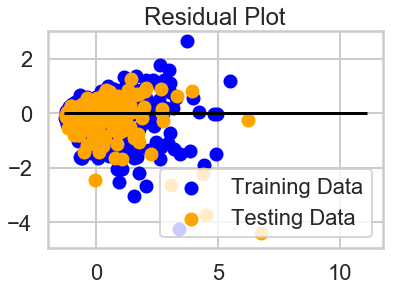

In [24]:
# Make predictions using the X_test_scaled data
# Plot y_test_scaled vs y_test_scaled
# Scatter plot y_test_scaled vs predictions

### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [25]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.3009512169590211, R2: 0.7912180244408303


In [26]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.3027179769588707, R2: 0.7899923518988324


In [27]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.30095161973726925, R2: 0.7912177450173437


In [28]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.3017172573892441, R2: 0.7906865913534475


### Saving the models

In [29]:
pkl_filename = "LinearRegression.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)